# Q1

### Mounting Google Drive (Data stored in Gdrive)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports

In [2]:
import torchvision.models as models
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import wandb
import matplotlib.pyplot as plt
import os
from torchvision import transforms
from torchvision.models import ResNet18_Weights # Importing the weights of the pretrained model
import time
from sklearn.metrics import f1_score, confusion_matrix

log_wandb = True

## 1.1

### Loading data

Train data shape = torch.Size([40000, 3, 36, 36])
Train label shape = torch.Size([40000])
Val data shape = torch.Size([10000, 3, 36, 36])
Val label shape = torch.Size([10000])
Test data shape = torch.Size([10000, 3, 36, 36])
Test label shape = torch.Size([10000])
Number of unique classes in the given dataset 10


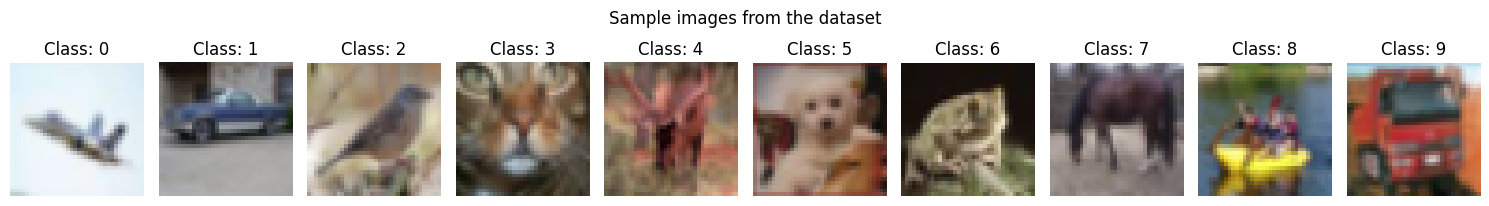

In [3]:
# Reading all the data stored as pytorch tensor and converting them to float, unsqueezing the labels array to add an extra dim
train_data_path = '/content/drive/MyDrive/cv_a2/q1/dataset/train_data.pt'
X_train = torch.load(train_data_path, weights_only=True).float()

train_label_path = '/content/drive/MyDrive/cv_a2/q1/dataset/train_labels.pt'
y_train = torch.load(train_label_path, weights_only=True)

val_data_size = 10000

# 10K Validation samples
X_val = X_train[:val_data_size]
y_val = y_train[:val_data_size]

# Remaining to the train
X_train = X_train[val_data_size:]
y_train = y_train[val_data_size:]

print(f"Train data shape = {X_train.shape}")
print(f"Train label shape = {y_train.shape}")

print(f"Val data shape = {X_val.shape}")
print(f"Val label shape = {y_val.shape}")

test_data_path = '/content/drive/MyDrive/cv_a2/q1/dataset/test_data.pt'
X_test = torch.load(test_data_path, weights_only=True).float()
print(f"Test data shape = {X_test.shape}")


test_label_path = '/content/drive/MyDrive/cv_a2/q1/dataset/test_labels.pt'
y_test = torch.load(test_label_path, weights_only=True)
print(f"Test label shape = {y_test.shape}")


num_classes = len(torch.unique(y_train))
print(f"Number of unique classes in the given dataset {num_classes}") # This will be used to remap the output of pytorch resent18 model to our custom dataset

sample_labels = torch.unique(y_train)
sample_data = []
for label in sample_labels:
    indices = (y_train == label).nonzero(as_tuple=True)[0]
    sample_data.append(X_train[indices[0]])

fig, axes = plt.subplots(1, len(sample_labels), figsize=(15, 2.5))
for i in range(len(sample_labels)):
    axes[i].imshow(sample_data[i].permute(1, 2, 0).cpu().numpy().astype(np.uint8)) # Permuting to put the 3 channels at the last dimension
    axes[i].set_title(f"Class: {sample_labels[i].item()}")
    axes[i].axis("off")

plt.tight_layout()
plt.suptitle("Sample images from the dataset")
plt.show()

## Definining Custom Dataset to apply transforms

In [4]:
class Q2Dataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        x = self.X[index]
        y = self.y[index]

        if self.transform:
            x = self.transform(x)  # Apply transformation to input

        return x, y

### Select device (For GPU training)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Training the model

In [6]:
def train_and_log(resnet18_model, X_train, y_train, X_val, y_val, X_test, y_test, device, epochs, batch_size, lr, project_name,
                  run_name, save_path, transform=None, op="Adam", loss_func="CrossEntropyLoss"):

    if os.path.exists(save_path):
        print("Model already exists, loading and returning the already saved model.")
        resnet18_model.load_state_dict(torch.load(save_path, map_location=torch.device(device), weights_only=True))
        return list(), list(), list(), resnet18_model.to(device) # Empty lists are just dummy to match the expected number of output for the else part
    else:
        if log_wandb == True:
            wandb.init(project=project_name, name=run_name)

        # Create DataLoaders
        train_dataset = Q2Dataset(X_train, y_train, transform)
        val_dataset = Q2Dataset(X_val, y_val, transform)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

        # Define Loss Function and Optimizer
        if loss_func == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif loss_func == "MSELoss":
            criterion = nn.MSELoss()

        if op == "Adam":
            optimizer = optim.Adam(resnet18_model.parameters(), lr=lr)
        elif op == "SGD":
            optimizer = optim.SGD(resnet18_model.parameters(), lr=lr)

        resnet18_model.to(device)

        train_loss_arr = []
        val_loss_arr = []

        # Training Loop
        for epoch in range(epochs):
            resnet18_model.train()
            running_train_loss = 0.0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = resnet18_model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_train_loss += loss.item()

            resnet18_model.eval()
            running_val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = resnet18_model(inputs)
                    # Calculating loss
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item()

            train_loss_arr.append(running_train_loss/len(train_loader))
            val_loss_arr.append(running_val_loss/len(val_loader))
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {round(running_train_loss/len(train_loader), 4)}, Val Loss: {round(running_val_loss/len(val_loader), 4)}")

            if log_wandb == True:
                wandb.log({"epoch" : epoch + 1, f"val_loss": running_val_loss/len(val_loader), f"train_loss": running_train_loss/len(train_loader)})

        print("Training Complete")

        # Testing the model
        # Creating the test dataloader
        test_dataset = Q2Dataset(X_test, y_test, transform)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        correct = 0
        total = 0
        test_loss = 0

        predictions = []
        gt_labels = []

        resnet18_model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = resnet18_model(inputs)
                # Calculating loss
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                # Getting the max predicted class value
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                predictions.extend(predicted.cpu().numpy())
                gt_labels.extend(labels.cpu().numpy())

        F1Score = f1_score(gt_labels, predictions, average='macro')
        ConfusionMatrix = confusion_matrix(gt_labels, predictions)

        # Printing the test loss and accuracy
        print(f"Test Loss: {round(test_loss/len(test_loader), 4)}")
        print(f"Test Accuracy: {round(100 * correct / total, 4)}%")
        print(f"F1-Score: {round(F1Score, 4)}")

        if log_wandb == True:
            wandb.log({"test_loss": test_loss/len(test_loader), "test_accuracy": 100 * correct / total})

        # Save the trained model
        torch.save(resnet18_model.state_dict(), save_path)

        # Return the trained model
        return ConfusionMatrix, train_loss_arr, val_loss_arr, resnet18_model

In [7]:
def run_model_and_plot_metrics(model, model_name, epochs=10, batch_size=32, lr=0.001, project_name="CV-A2-Q1", transform=None):
    start_time = time.time()
    conf_mat, train_loss_arr, val_loss_arr, trained_model = train_and_log(model, X_train, y_train, X_val, y_val, X_test, y_test,
                                                                      device, epochs=10, batch_size=32, lr=0.001, project_name="CV-A2-Q1",
                                                                      run_name=model_name, save_path=f"/content/drive/MyDrive/cv_a2/q1/saved_models/{model_name}.pth", transform=transform)
    end_time = time.time()
    print(f"Time taken for training: {round(end_time - start_time, 4)} seconds")

    if len(train_loss_arr) > 0:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].plot(train_loss_arr, label="Train Loss")
        ax[0].plot(val_loss_arr, label="Val Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")

        im = ax[1].imshow(conf_mat, cmap='viridis')
        ax[1].set_xlabel("Predicted")
        ax[1].set_ylabel("True")

        plt.colorbar(im, ax=ax[1])
        plt.suptitle("Evaluation Metrics")
        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        print("Model trained previously so not training again.")

## Not pretrained model

Epoch [1/10], Train Loss: 1.428, Val Loss: 1.3496
Epoch [2/10], Train Loss: 1.0331, Val Loss: 1.0377
Epoch [3/10], Train Loss: 0.85, Val Loss: 1.0252
Epoch [4/10], Train Loss: 0.7036, Val Loss: 0.8327
Epoch [5/10], Train Loss: 0.5786, Val Loss: 0.8533
Epoch [6/10], Train Loss: 0.4619, Val Loss: 0.8172
Epoch [7/10], Train Loss: 0.3522, Val Loss: 0.8156
Epoch [8/10], Train Loss: 0.267, Val Loss: 0.862
Epoch [9/10], Train Loss: 0.2013, Val Loss: 0.9961
Epoch [10/10], Train Loss: 0.1633, Val Loss: 1.0306
Training Complete
Test Loss: 1.0739
Test Accuracy: 73.83%
F1-Score: 0.7374
Time taken for training: 218.4834 seconds


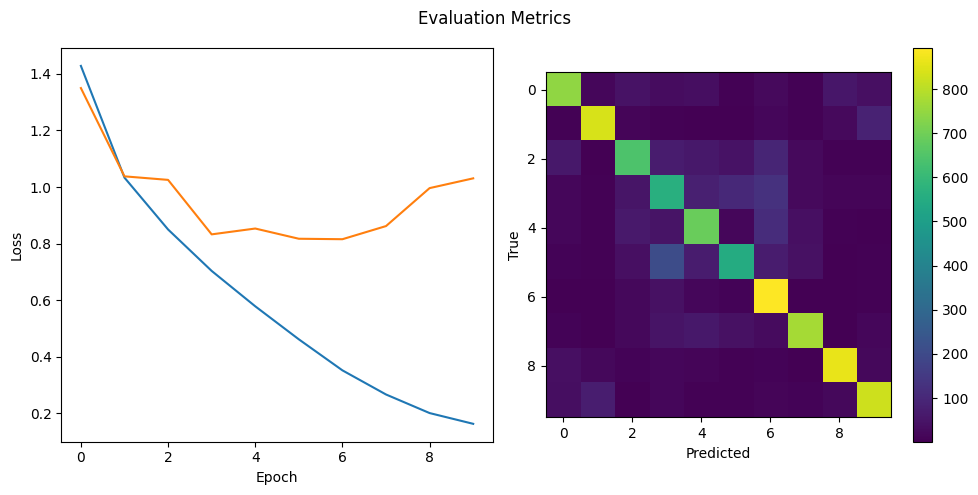

In [16]:
# Loading the architecture of ResNet18 model from PyTorch without weights
resnet18_model_scratch = models.resnet18(weights=None)
# Remapping the output of ResNet model (1000) to the number of classes present in our custom dataset (num_classes)
resnet18_model_scratch.fc = torch.nn.Linear(resnet18_model_scratch.fc.in_features, num_classes)
# Training the model from scratch on the custom dataset
run_model_and_plot_metrics(resnet18_model_scratch, "ResNet18_scratch")

## Pretrained model

Epoch [1/10], Train Loss: 1.0278, Val Loss: 1.0344
Epoch [2/10], Train Loss: 0.7007, Val Loss: 0.7627
Epoch [3/10], Train Loss: 0.5754, Val Loss: 0.7708
Epoch [4/10], Train Loss: 0.446, Val Loss: 0.6707
Epoch [5/10], Train Loss: 0.3644, Val Loss: 0.6869
Epoch [6/10], Train Loss: 0.2881, Val Loss: 0.6766
Epoch [7/10], Train Loss: 0.2258, Val Loss: 0.7116
Epoch [8/10], Train Loss: 0.1784, Val Loss: 0.8679
Epoch [9/10], Train Loss: 0.1525, Val Loss: 0.8032
Epoch [10/10], Train Loss: 0.1486, Val Loss: 0.7284
Training Complete
Test Loss: 0.7322
Test Accuracy: 79.94%
F1-Score: 0.8004
Time taken for training: 218.4379 seconds


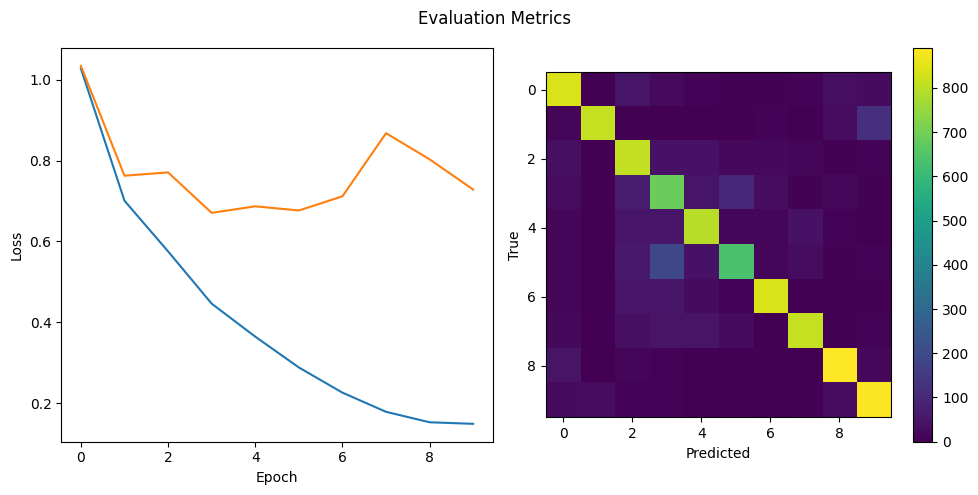

In [17]:
# Loading the architecture of ResNet18 model from PyTorch with weights
resnet18_pretrained_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1) # Loading the weights of 1K ImageNet pretrained model
# Remapping the output of ResNet model (1000) to the number of classes present in our custom dataset (num_classes)
resnet18_pretrained_model.fc = torch.nn.Linear(resnet18_pretrained_model.fc.in_features, num_classes)
# Tuning the pretrained model for our custom dataset
run_model_and_plot_metrics(resnet18_pretrained_model, "ResNet18_finetuned")

## Printing the spatial dimensions of in each layer

In [8]:
resnet18_model = models.resnet18(weights=None)
resnet18_model.fc = torch.nn.Linear(resnet18_model.fc.in_features, num_classes)
resnet18_model.to(device)

# Sample input (Similar to given dataset)
input_image = torch.randn(1, 3, 36, 36).to(device)

# Hook function
def hook_fn(model, input, output):
    print(f"{model.__class__.__name__} output shape: {output.shape}")

# Registering forward hook to all the blocks
for name, layer in resnet18_model.named_children():
    layer.register_forward_hook(hook_fn)

# Doing a forward pass for all the layers to print
with torch.no_grad():
    resnet18_model(input_image)

Conv2d output shape: torch.Size([1, 64, 18, 18])
BatchNorm2d output shape: torch.Size([1, 64, 18, 18])
ReLU output shape: torch.Size([1, 64, 18, 18])
MaxPool2d output shape: torch.Size([1, 64, 9, 9])
Sequential output shape: torch.Size([1, 64, 9, 9])
Sequential output shape: torch.Size([1, 128, 5, 5])
Sequential output shape: torch.Size([1, 256, 3, 3])
Sequential output shape: torch.Size([1, 512, 2, 2])
AdaptiveAvgPool2d output shape: torch.Size([1, 512, 1, 1])
Linear output shape: torch.Size([1, 10])


> In ResNet18, due to an input image size of 36 x 36 instead of 224 x 224, the feature map just before max pooling is 1 x 512 x 2 x 2 (B x C x H x W). Batch size is 1 because we just passes a sample single input from the model for printing the layer stats.

## 1.2

## Training both the models on custom 224x224 dataset

Epoch [1/10], Train Loss: 1.4823, Val Loss: 1.1423
Epoch [2/10], Train Loss: 0.9576, Val Loss: 0.9424
Epoch [3/10], Train Loss: 0.7319, Val Loss: 0.7391
Epoch [4/10], Train Loss: 0.5911, Val Loss: 0.6019
Epoch [5/10], Train Loss: 0.4725, Val Loss: 0.593
Epoch [6/10], Train Loss: 0.3772, Val Loss: 0.57
Epoch [7/10], Train Loss: 0.2827, Val Loss: 0.5919
Epoch [8/10], Train Loss: 0.2015, Val Loss: 0.6643
Epoch [9/10], Train Loss: 0.1518, Val Loss: 0.6304
Epoch [10/10], Train Loss: 0.104, Val Loss: 0.7983
Training Complete
Test Loss: 0.8106
Test Accuracy: 80.81%
F1-Score: 0.8055
Time taken for training: 1566.9525 seconds


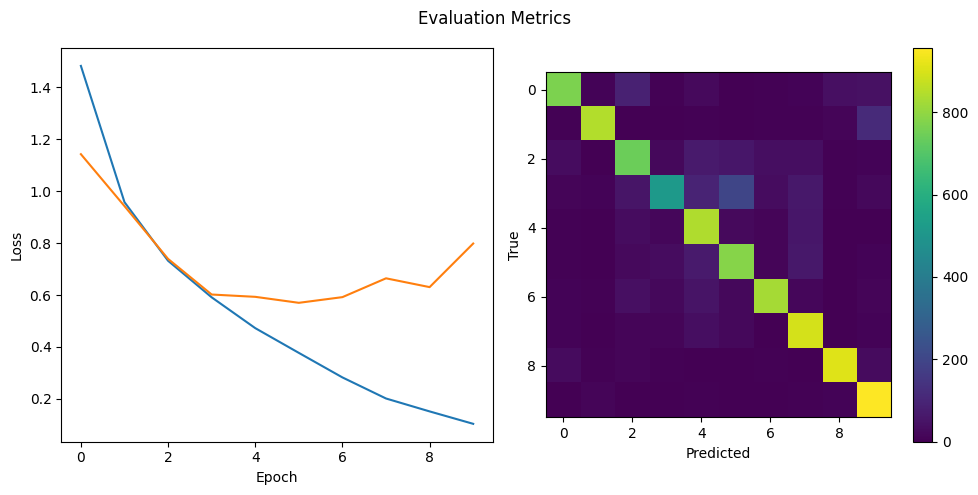

In [18]:
# Loading the architecture of ResNet18 model from PyTorch without weights
resnet18_model_scratch_resized = models.resnet18(weights=None)
# Remapping the output of ResNet model (1000) to the number of classes present in our custom dataset (num_classes)
resnet18_model_scratch_resized.fc = torch.nn.Linear(resnet18_model_scratch_resized.fc.in_features, num_classes)
# Training the model from scratch on the custom dataset
run_model_and_plot_metrics(resnet18_model_scratch_resized, "ResNet18_scratch_resized", transform=transforms.Resize((224, 224)))

Epoch [1/10], Train Loss: 1.4661, Val Loss: 1.0868
Epoch [2/10], Train Loss: 0.943, Val Loss: 0.8398
Epoch [3/10], Train Loss: 0.7195, Val Loss: 0.6615
Epoch [4/10], Train Loss: 0.5781, Val Loss: 0.5941
Epoch [5/10], Train Loss: 0.4661, Val Loss: 0.5657
Epoch [6/10], Train Loss: 0.3693, Val Loss: 0.5777
Epoch [7/10], Train Loss: 0.277, Val Loss: 0.5746
Epoch [8/10], Train Loss: 0.1952, Val Loss: 0.614
Epoch [9/10], Train Loss: 0.141, Val Loss: 0.6314
Epoch [10/10], Train Loss: 0.1076, Val Loss: 0.7126
Training Complete
Test Loss: 0.7238
Test Accuracy: 82.11%
F1-Score: 0.8213
Time taken for training: 1557.8266 seconds


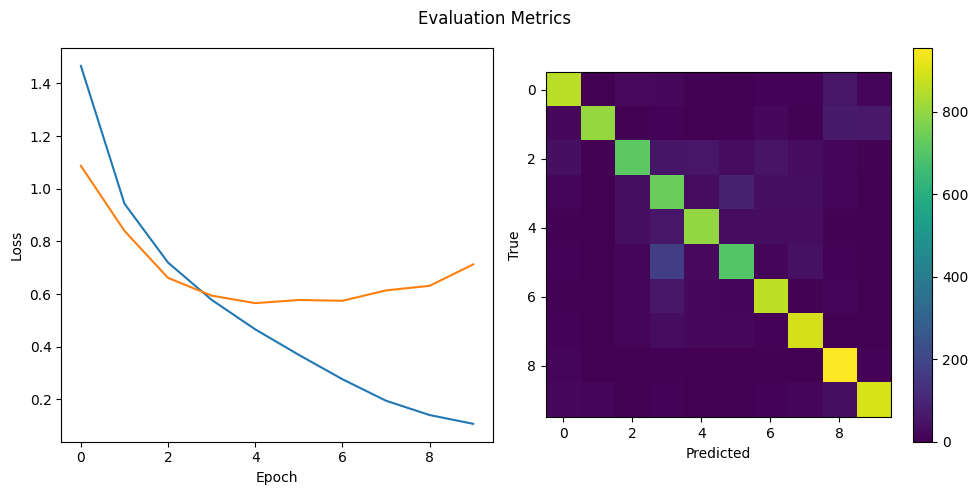

In [19]:
# Loading the architecture of ResNet18 model from PyTorch without weights
resnet18_model_pretrained_resized = models.resnet18(weights=None)
# Remapping the output of ResNet model (1000) to the number of classes present in our custom dataset (num_classes)
resnet18_model_pretrained_resized.fc = torch.nn.Linear(resnet18_model_pretrained_resized.fc.in_features, num_classes)
# Training the model from pretrained on the custom dataset
run_model_and_plot_metrics(resnet18_model_pretrained_resized, "ResNet18_pretrained_resized", transform=transforms.Resize((224, 224)))

### Comparison of metrics

| Model | Image Dimensions | Test Accuracy | Test Loss | Test F1 Score |
| --- | --- | --- | --- | --- |
| ResNet18 Scratch | 32x32 | 73.83% | 1.0739 | 0.7374 |
| ResNet18 Pretrained | 32x32 | 79.94% | 0.7322 | 0.8004 |
| ResNet18 Scratch | 224x224 | 80.81% | 0.8106 | 0.8055 |
| ResNet18 Pretrained | 224x224 | 82.11% | 0.7238 | 0.8213 |

> General trend is evident that pretrained models when fine-tuned perform better than training the model from scratch for the same number of epochs and also increasing the size of input also leads to improved performance.


> Accuracy is because of larger image, but the time taken for training is also more, so there is this trade off between accuracy and time taken for training. Time for training is directly related to computation cost so more time => more computation.

## 1.3

## Modification 1 (to Scratch) to initial layers (Conv1 = 7x7 -> 3x3) and keeping stride of 2

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: vinitmehta-colab3 (vinitmehta-colab3-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch [1/10], Train Loss: 1.3468, Val Loss: 1.3032
Epoch [2/10], Train Loss: 0.9684, Val Loss: 0.9526
Epoch [3/10], Train Loss: 0.7916, Val Loss: 0.8202
Epoch [4/10], Train Loss: 0.6469, Val Loss: 0.7469
Epoch [5/10], Train Loss: 0.527, Val Loss: 0.7304
Epoch [6/10], Train Loss: 0.4091, Val Loss: 0.8853
Epoch [7/10], Train Loss: 0.3088, Val Loss: 0.8211
Epoch [8/10], Train Loss: 0.2344, Val Loss: 0.9383
Epoch [9/10], Train Loss: 0.1755, Val Loss: 1.0757
Epoch [10/10], Train Loss: 0.1478, Val Loss: 0.9794
Training Complete
Test Loss: 1.0466
Test Accuracy: 74.56%
F1-Score: 0.7481
Time taken for training: 251.345 seconds


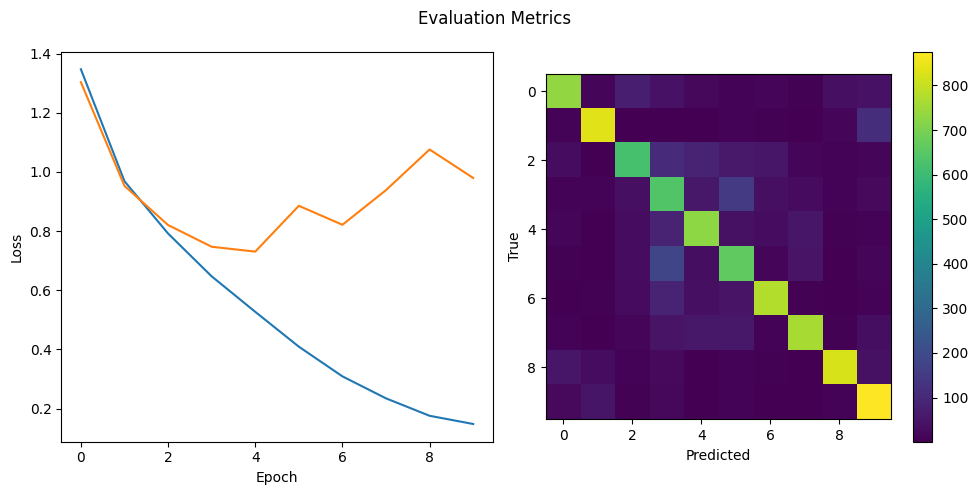

In [10]:
class ResNet18Modified1(nn.Module):
    def __init__(self):
        super(ResNet18Modified1, self).__init__()
        self.model = models.resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        return self.model(x)

# Loading the architecture of ResNet18 model from PyTorch without weights
resnet18_model_modified1 = ResNet18Modified1()
# Remapping the output of ResNet model (1000) to the number of classes present in our custom dataset (num_classes)
resnet18_model_modified1.model.fc = torch.nn.Linear(resnet18_model_modified1.model.fc.in_features, num_classes)
# Training the model from pretrained on the custom dataset
run_model_and_plot_metrics(resnet18_model_modified1, "ResNet18_scratch_modified1")

## Modification 2 (to Scratch) to initial layers (Conv1 = 7x7 -> 5x5) and keeping stride of 3

Epoch [1/10], Train Loss: 1.4911, Val Loss: 1.5192
Epoch [2/10], Train Loss: 1.1466, Val Loss: 1.0995
Epoch [3/10], Train Loss: 0.9791, Val Loss: 1.0292
Epoch [4/10], Train Loss: 0.865, Val Loss: 0.8996
Epoch [5/10], Train Loss: 0.7565, Val Loss: 0.9434
Epoch [6/10], Train Loss: 0.6654, Val Loss: 0.9521
Epoch [7/10], Train Loss: 0.573, Val Loss: 0.8859
Epoch [8/10], Train Loss: 0.4919, Val Loss: 0.9607
Epoch [9/10], Train Loss: 0.411, Val Loss: 0.9509
Epoch [10/10], Train Loss: 0.3392, Val Loss: 0.9535
Training Complete
Test Loss: 0.9902
Test Accuracy: 70.96%
F1-Score: 0.7129
Time taken for training: 237.7099 seconds


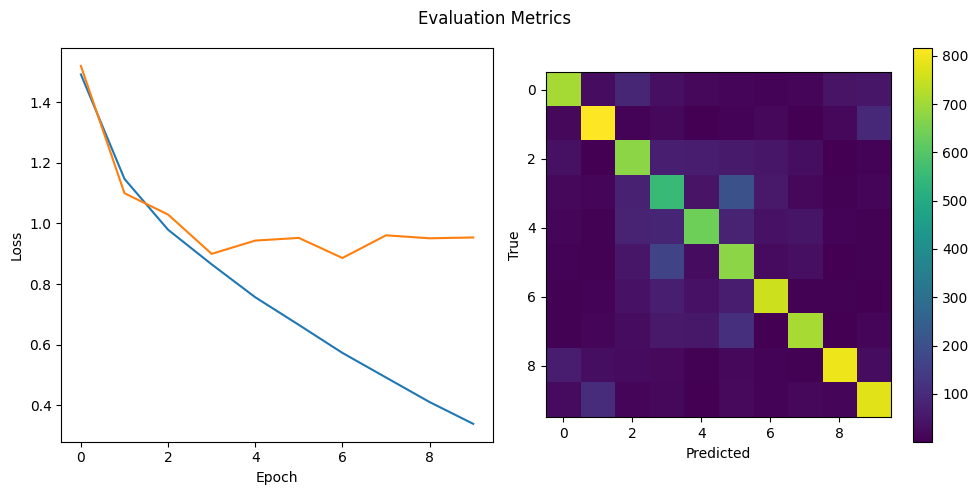

In [11]:
class ResNet18Modified2(nn.Module):
    def __init__(self):
        super(ResNet18Modified2, self).__init__()
        self.model = models.resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=3, padding=1, bias=False)

    def forward(self, x):
        return self.model(x)

# Loading the architecture of ResNet18 model from PyTorch without weights
resnet18_model_modified2 = ResNet18Modified2()
# Remapping the output of ResNet model (1000) to the number of classes present in our custom dataset (num_classes)
resnet18_model_modified2.model.fc = torch.nn.Linear(resnet18_model_modified2.model.fc.in_features, num_classes)
# Training the model from pretrained on the custom dataset
run_model_and_plot_metrics(resnet18_model_modified2, "ResNet18_scratch_modified2")

## Modification 3 (to Scratch) to initial layers (Conv1 = 7x7 -> 7x7) and keeping stride of 3 and maxpooling kernel size as 3 and stride 2

Epoch [1/10], Train Loss: 1.4824, Val Loss: 1.414
Epoch [2/10], Train Loss: 1.1522, Val Loss: 1.1676
Epoch [3/10], Train Loss: 1.0018, Val Loss: 1.1196
Epoch [4/10], Train Loss: 0.8902, Val Loss: 0.9378
Epoch [5/10], Train Loss: 0.7909, Val Loss: 0.9165
Epoch [6/10], Train Loss: 0.6929, Val Loss: 0.8456
Epoch [7/10], Train Loss: 0.6085, Val Loss: 0.8584
Epoch [8/10], Train Loss: 0.5168, Val Loss: 0.885
Epoch [9/10], Train Loss: 0.4474, Val Loss: 1.0536
Epoch [10/10], Train Loss: 0.3726, Val Loss: 1.0001
Training Complete
Test Loss: 1.0284
Test Accuracy: 70.23%
F1-Score: 0.6993
Time taken for training: 239.8943 seconds


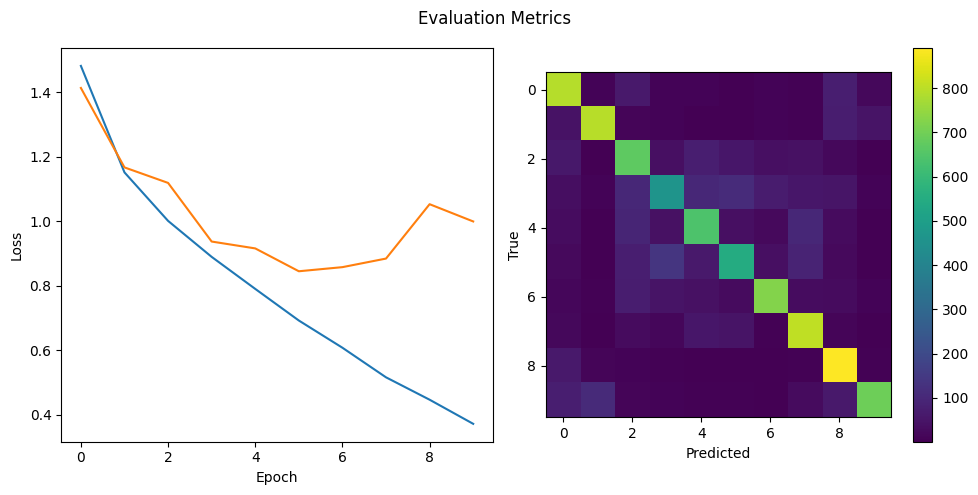

In [ ]:
class ResNet18Modified3(nn.Module):
    def __init__(self):
        super(ResNet18Modified3, self).__init__()
        self.model = models.resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=3, padding=1, bias=False)
        self.model.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        return self.model(x)

# Loading the architecture of ResNet18 model from PyTorch without weights
resnet18_model_modified3 = ResNet18Modified3()
# Remapping the output of ResNet model (1000) to the number of classes present in our custom dataset (num_classes)
resnet18_model_modified3.model.fc = torch.nn.Linear(resnet18_model_modified3.model.fc.in_features, num_classes)
# Training the model from pretrained on the custom dataset
run_model_and_plot_metrics(resnet18_model_modified3, "ResNet18_scratch_modified3")

## Modification 1 (to Pretrained) to initial layers (Conv1 = 7x7 -> 3x3) and keeping stride of 2 + Xavier Normal Initialization

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


Epoch [1/10], Train Loss: 1.4028, Val Loss: 1.1185
Epoch [2/10], Train Loss: 0.9815, Val Loss: 0.9582
Epoch [3/10], Train Loss: 0.7881, Val Loss: 0.8489
Epoch [4/10], Train Loss: 0.6477, Val Loss: 0.8317
Epoch [5/10], Train Loss: 0.5231, Val Loss: 0.8306
Epoch [6/10], Train Loss: 0.4088, Val Loss: 0.7342
Epoch [7/10], Train Loss: 0.3144, Val Loss: 0.7693
Epoch [8/10], Train Loss: 0.2554, Val Loss: 0.803
Epoch [9/10], Train Loss: 0.2066, Val Loss: 0.8693
Epoch [10/10], Train Loss: 0.1571, Val Loss: 0.8735
Training Complete
Test Loss: 0.9434
Test Accuracy: 75.66%
F1-Score: 0.7551
Time taken for training: 215.9409 seconds


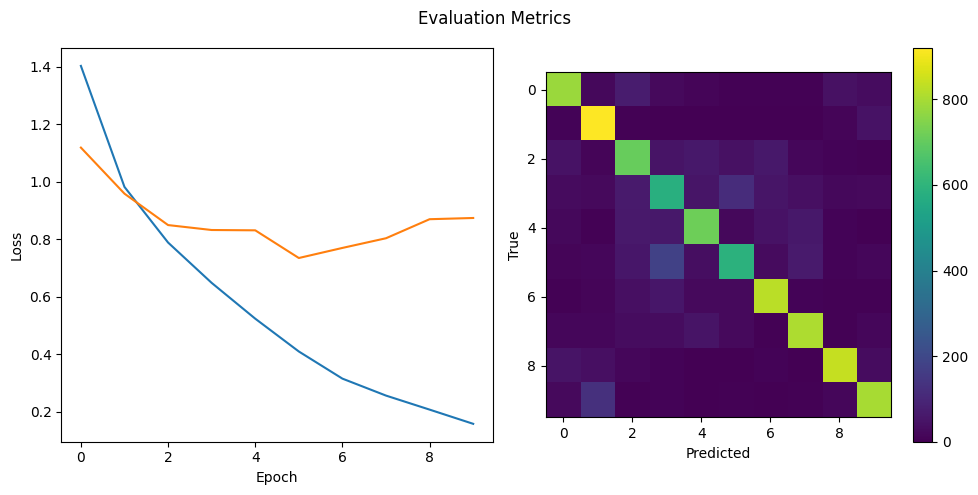

In [13]:
class ResNet18Modified1_Pretrained(nn.Module):
    def __init__(self):
        super(ResNet18Modified1_Pretrained, self).__init__()
        self.model = models.resnet18(weights='DEFAULT')
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)

        # Xavier Normal Initialization:
        # Initializes weights with values drawn from a normal distribution
        # with mean = 0 and variance = 2 / (fan_in + fan_out),
        # where fan_in = number of input channels and fan_out = number of output channels.
        # This helps maintain variance across layers, improving training stability.
        nn.init.xavier_normal_(self.model.conv1.weight)

    def forward(self, x):
        return self.model(x)

# Loading the architecture of ResNet18 model from PyTorch without weights
resnet18_model_modified1_pretrained = ResNet18Modified1_Pretrained()
# Remapping the output of ResNet model (1000) to the number of classes present in our custom dataset (num_classes)
resnet18_model_modified1_pretrained.model.fc = torch.nn.Linear(resnet18_model_modified1_pretrained.model.fc.in_features, num_classes)
# Training the model from pretrained on the custom dataset
run_model_and_plot_metrics(resnet18_model_modified1_pretrained, "ResNet18_pretrained_modified1")

## Modification 2 (to Pretrained) to initial layers (Conv1 = 7x7 -> 5x5) and keeping stride of 3 + Kaiming Normal Initialization

Epoch [1/10], Train Loss: 1.5006, Val Loss: 1.4322
Epoch [2/10], Train Loss: 1.1498, Val Loss: 1.0676
Epoch [3/10], Train Loss: 0.9932, Val Loss: 1.0839
Epoch [4/10], Train Loss: 0.8721, Val Loss: 1.0305
Epoch [5/10], Train Loss: 0.7662, Val Loss: 0.9158
Epoch [6/10], Train Loss: 0.6675, Val Loss: 0.8875
Epoch [7/10], Train Loss: 0.5784, Val Loss: 0.9741
Epoch [8/10], Train Loss: 0.4914, Val Loss: 0.8984
Epoch [9/10], Train Loss: 0.4108, Val Loss: 0.9787
Epoch [10/10], Train Loss: 0.3471, Val Loss: 0.9242
Training Complete
Test Loss: 0.9329
Test Accuracy: 71.81%
F1-Score: 0.716
Time taken for training: 239.4774 seconds


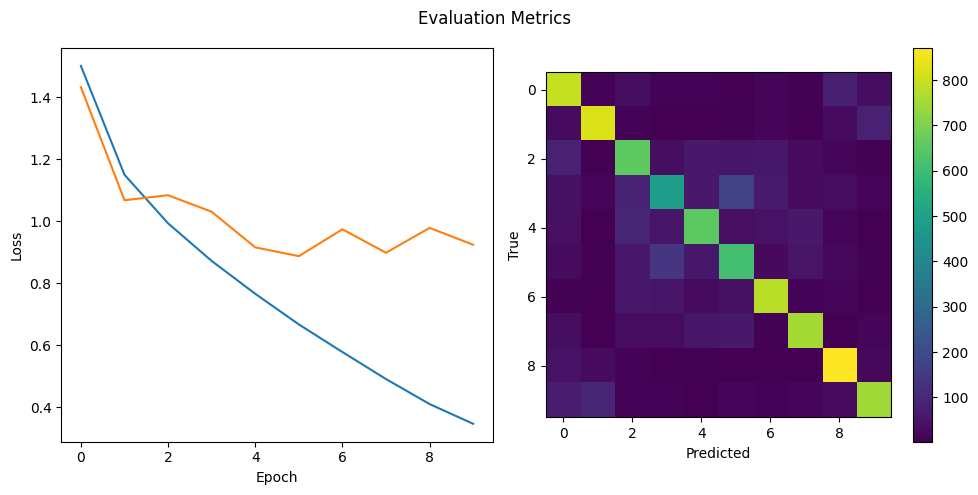

In [14]:
class ResNet18Modified2_Pretrained(nn.Module):
    def __init__(self):
        super(ResNet18Modified2_Pretrained, self).__init__()
        self.model = models.resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=3, padding=1, bias=False)

        # fan_in (default): Maintains variance during the forward pass (scales by input channels)
        # fan_out: Maintains variance during the backward pass (scales by output channels)
        # Scaling is based on output channels since only these weights are randomly initialized
        # During backpropagation, gradients are scaled by the number of output channels,
        # ensuring variance remains stable
        nn.init.kaiming_normal_(self.model.conv1.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        return self.model(x)

# Loading the architecture of ResNet18 model from PyTorch without weights
resnet18_model_modified2_pretrained = ResNet18Modified2_Pretrained()
# Remapping the output of ResNet model (1000) to the number of classes present in our custom dataset (num_classes)
resnet18_model_modified2_pretrained.model.fc = torch.nn.Linear(resnet18_model_modified2_pretrained.model.fc.in_features, num_classes)
# Training the model from pretrained on the custom dataset
run_model_and_plot_metrics(resnet18_model_modified2_pretrained, "ResNet18_pretrained_modified2")

## Modification 3 (to Pretrained) to initial layers (Conv1 = 7x7 -> 7x7) and keeping stride of 3 and maxpooling kernel size as 3 and stride 2 + Xavier Normal Initialization

Epoch [1/10], Train Loss: 1.4987, Val Loss: 1.4216
Epoch [2/10], Train Loss: 1.1641, Val Loss: 1.2826
Epoch [3/10], Train Loss: 1.0048, Val Loss: 1.0721
Epoch [4/10], Train Loss: 0.8934, Val Loss: 0.9138
Epoch [5/10], Train Loss: 0.8038, Val Loss: 0.9997
Epoch [6/10], Train Loss: 0.7114, Val Loss: 0.9074
Epoch [7/10], Train Loss: 0.6237, Val Loss: 1.0846
Epoch [8/10], Train Loss: 0.5378, Val Loss: 0.8849
Epoch [9/10], Train Loss: 0.4572, Val Loss: 0.926
Epoch [10/10], Train Loss: 0.384, Val Loss: 0.9284
Training Complete
Test Loss: 0.9546
Test Accuracy: 71.49%
F1-Score: 0.7161
Time taken for training: 239.7014 seconds


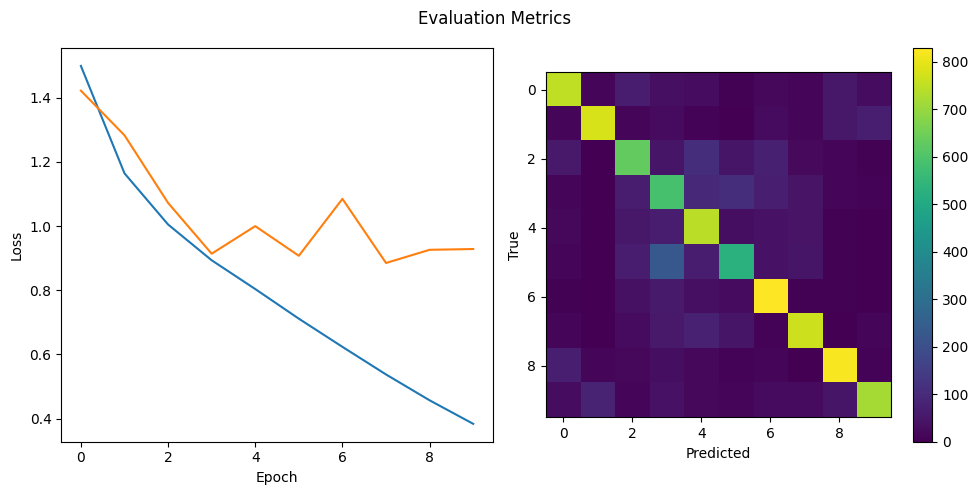

In [15]:
class ResNet18Modified3_Pretrained(nn.Module):
    def __init__(self):
        super(ResNet18Modified3_Pretrained, self).__init__()
        self.model = models.resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=3, padding=1, bias=False)
        self.model.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)

        nn.init.xavier_normal_(self.model.conv1.weight)

    def forward(self, x):
        return self.model(x)

# Loading the architecture of ResNet18 model from PyTorch without weights
resnet18_model_modified3_pretrained = ResNet18Modified3_Pretrained()
# Remapping the output of ResNet model (1000) to the number of classes present in our custom dataset (num_classes)
resnet18_model_modified3_pretrained.model.fc = torch.nn.Linear(resnet18_model_modified3_pretrained.model.fc.in_features, num_classes)
# Training the model from pretrained on the custom dataset
run_model_and_plot_metrics(resnet18_model_modified3_pretrained, "ResNet18_pretrained_modified3")

## 1.4

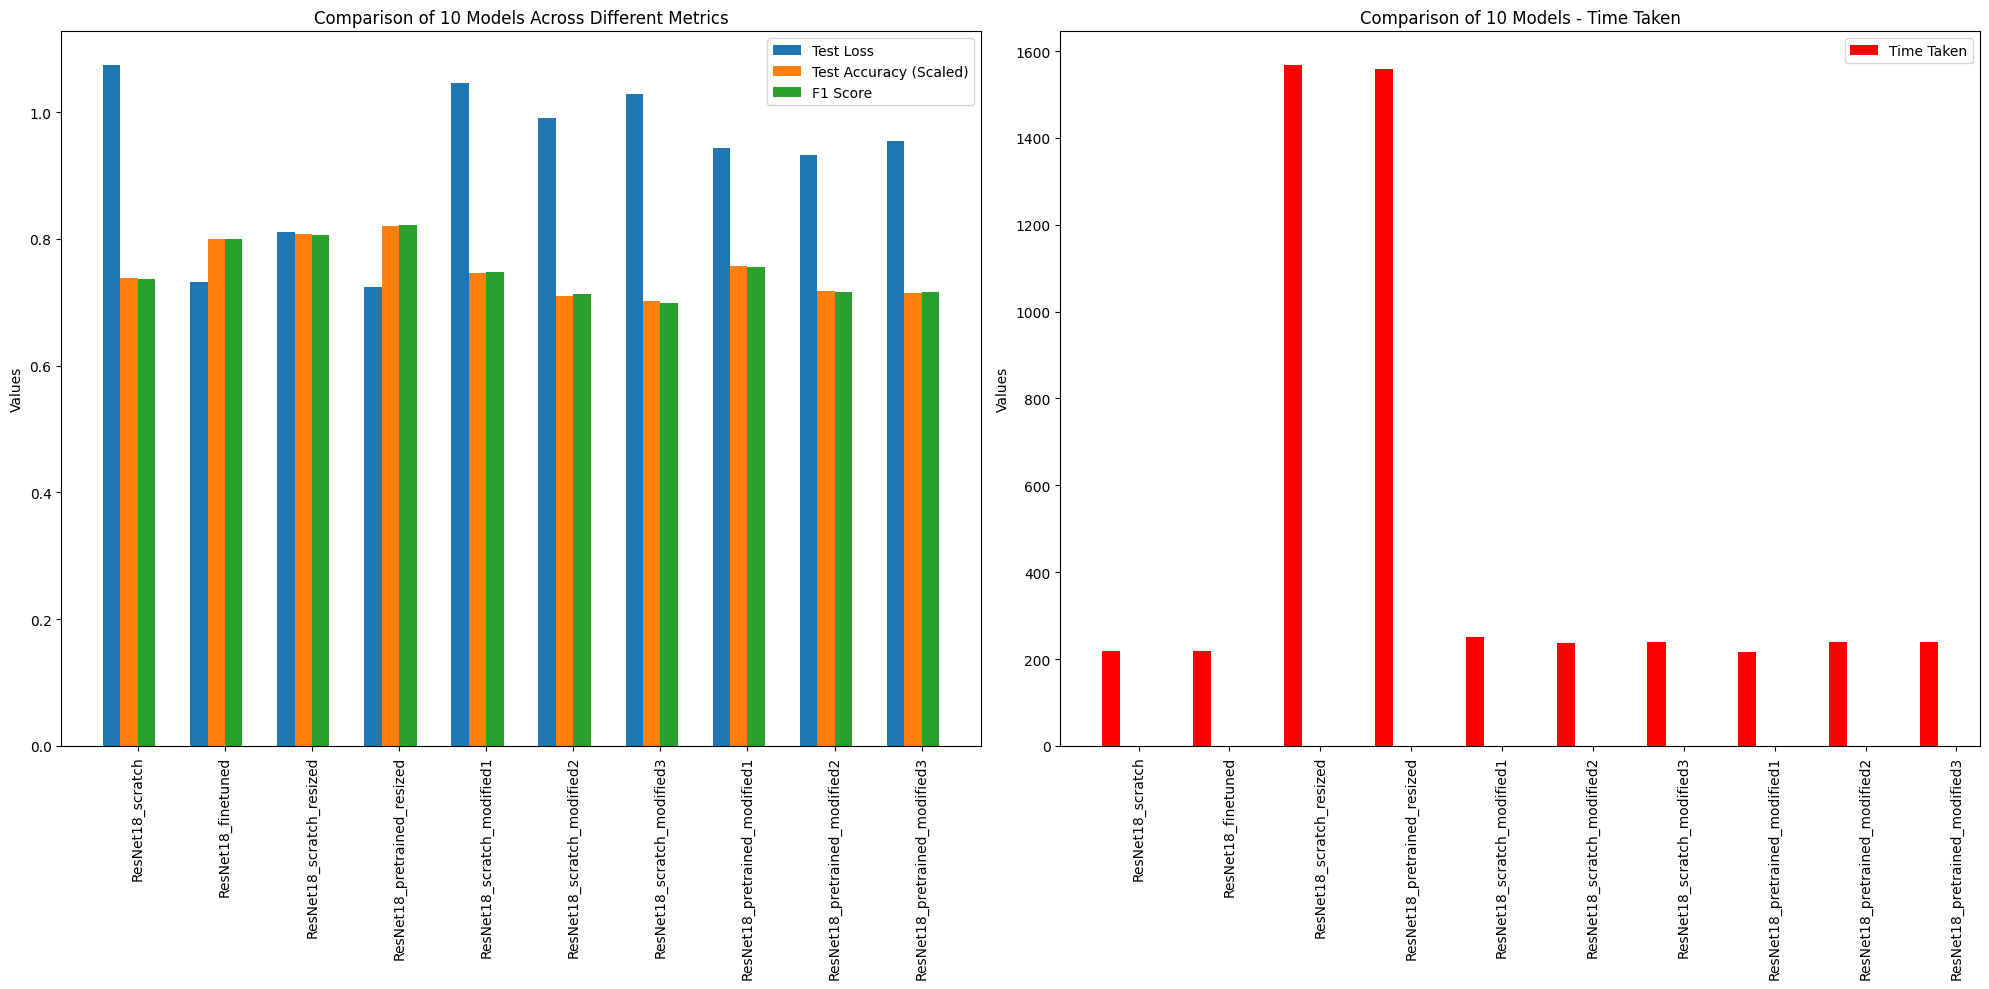

In [32]:
model_names = ["ResNet18_scratch", "ResNet18_finetuned", "ResNet18_scratch_resized", "ResNet18_pretrained_resized",
          "ResNet18_scratch_modified1", "ResNet18_scratch_modified2", "ResNet18_scratch_modified3",
          "ResNet18_pretrained_modified1", "ResNet18_pretrained_modified2", "ResNet18_pretrained_modified3"]

# Data
loss = [1.0739, 0.7322, 0.8106, 0.7238, 1.0466, 0.9902, 1.0284, 0.9434, 0.9329, 0.9546]
accuracy = [73.83, 79.94, 80.81, 82.11, 74.56, 70.96, 70.23, 75.66, 71.81, 71.49]
f1_score = [0.7374, 0.8004, 0.8055, 0.8213, 0.7481, 0.7129, 0.6993, 0.7551, 0.716, 0.7161]
time_taken = [218.4834, 218.4379, 1566.9525, 1557.8266, 251.345, 237.7099, 239.8943, 215.9409, 239.4774, 239.7014]

# On the scale of 0 to 1
accuracy = [acc / 100 for acc in accuracy]

# Labels for metrics (Plotting time different from other metrics as it's scale is pretty different as compared to other metrics which are on about same scale)
metrics1 = ["Test Loss", "Test Accuracy (Scaled)", "F1 Score"]
data1 = [loss, accuracy, f1_score]

metrics2 = ["Time Taken"]
data2 = [time_taken]

x = np.arange(len(model_names))
width = 0.2

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for i, (metric, values) in enumerate(zip(metrics1, data1)):
    axes[0].bar(x + i * width, values, width, label=metric)
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(model_names, rotation=90)
axes[0].set_ylabel("Values")
axes[0].set_title("Comparison of 10 Models Across Different Metrics")
axes[0].legend()

for i, (metric, values) in enumerate(zip(metrics2, data2)):
    axes[1].bar(x + i * width, values, width, label=metric, color='r')
axes[1].set_xticks(x + width * 1.5)
axes[1].set_xticklabels(model_names, rotation=90)
axes[1].set_ylabel("Values")
axes[1].set_title("Comparison of 10 Models - Time Taken")
axes[1].legend()

plt.tight_layout()
plt.show()

### Key Insights from Model Comparisons

From the plotted data, we observe several important trends:

1. **Effect of Image Resizing**  
   - Resizing images improves model accuracy significantly.  
   - However, it also increases the training time substantially.

2. **Impact of Kernel Size and Stride**  
   - Smaller kernel sizes provide better accuracy.  
   - Larger kernels (e.g., 5x5) do not perform well, especially for small images.  
   - Increasing stride reduces accuracy, suggesting that smaller kernels are better at capturing fine details.

3. **Comparison of Initialization Methods**  
   - Kaiming Normal initialization outperforms Xavier Normal.  
   - The drop in accuracy seen in models trained from scratch (modified2 vs. modified3) is compensated in pretrained models.  
   - This suggests that Kaiming Normal helps maintain performance despite architectural changes.

4. **Effect of Removing Max Pooling**  
   - Without max pooling, spatial dimensions are preserved, allowing the model to learn more features.  
   - This is beneficial for small images where reducing dimensions too early can lose important information.

5. **Pretrained vs. Training from Scratch**  
   - Pretrained models perform better than those trained from scratch.  
   - This is because pretrained weights are already optimized for general features and can be fine-tuned for specific tasks.  
   - Training from scratch is harder with a small dataset and takes longer to converge.

6. **Effect of Image Size**  
   - Using 224x224 images instead of 36x36 leads to better performance.  
   - Larger images contain more details, which helps the model learn better.  
   - However, training with larger images takes more time.

7. **Pretrained Model Weight Adjustment**  
   - In a pretrained model, the first layer is initialized from scratch while others retain their original weights.  
   - Early training may be affected due to mismatched feature learning, but later fine-tuning helps adapt to the dataset.

### **Best Practices for High Accuracy**
- Use **larger input images** for better feature learning.  
- Prefer **smaller kernel sizes** in the initial layers to capture local patterns effectively.  
- **Fine-tune pretrained models** instead of training from scratch for better accuracy and efficiency.  


> More or less in my case accuracy and F1-Score went hand in hand.

<span style="color:red;"> Please note that all the WandB plots are given separately as an image, also there was a slight mistake so all the plots have been by mistake plotted one after the other instead of getting a separate plot for each. You can find my wandb workspace here: https://wandb.ai/vinitmehta-colab3-iiit-hyderabad/CV-A2-Q1?nw=nwuservinitmehtacolab3</span>